# DCGANs example

## 초기 설정들

In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import time 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

os.environ["CUDA_VISIBLE_DEVICES"]="0"


import pickle
import gzip

file_dir = 'anoGANs_MNIST_data/'

with gzip.open(file_dir + 'test_normal_data.pickle.gzip','rb') as f :
    test_normal_data = pickle.load(f)
    print('test_normal_data : ' ,test_normal_data.shape)

with gzip.open(file_dir + 'test_anomalous_data.pickle.gzip','rb') as f :
    test_anomalous_data = pickle.load(f)
    print('test_anomalous_data : ',test_anomalous_data.shape)
    
with gzip.open(file_dir + 'train_normal_data.pickle.gzip','rb') as f :
    train_normal_data = pickle.load(f)
    print('train_normal_data : ', train_normal_data.shape)
    
with gzip.open(file_dir + 'train_anomalous_data.pickle.gzip','rb') as f :
    train_anomalous_data = pickle.load(f)
    print('train_anomalous_data : ',train_anomalous_data.shape )

def idx_shuffle(x) : 
    l = x.shape[0]
    idx = np.arange(l)
    np.random.shuffle(idx)
    shuffled_x = np.empty(x.shape)

    for i in range(l):
        shuffled_x[idx[i]] = x[i]
    
    return shuffled_x

def mnist_4by4_save(samples,path):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)    
    gs.update(wspace=0.05, hspace=0.05) #이미지 사이간격 조절
  
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
   
        plt.imshow(sample.reshape(64, 64), cmap='Greys_r',clim=(0.0,1.0))
    plt.colorbar()
    plt.savefig(path, bbox_inches='tight')
    plt.close(fig)
   
    return None

def gan_loss_graph_save(G_loss,D_loss,path):
    x1 = range(len(G_loss))
    x2 = range(len(D_loss))
      
    y1 = G_loss
    y2 = D_loss
  
      
    plt.plot(x1,y1,label='G_loss') 
    plt.plot(x2,y2,label='D_loss') 
  
    plt.xlabel('weight per update')
    plt.ylabel('loss')             
    plt.legend(loc=4)              
    plt.grid(True)
    plt.tight_layout()
  
    plt.savefig(path)              

    return None

file_name = 'ex_DCGANs_1'

if not os.path.isdir(file_name) :
    os.mkdir(file_name)


test_normal_data :  (5139, 64, 64, 1)
test_anomalous_data :  (4861, 64, 64, 1)
train_normal_data :  (28038, 64, 64, 1)
train_anomalous_data :  (26962, 64, 64, 1)


## 네트워크 정의

D부분을 encoder와 discriminator로 나눈 이유는 encoder를 나중에 feature map으로 쓰기 위해서 편의상 나누어서 정의함



In [2]:

def G(x,isTrain = True, reuse = False, name = 'G') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)

    with tf.variable_scope('G',reuse=reuse)  :
        
        #x = (-1, 1, 1, 100)

        conv1 = tf.layers.conv2d_transpose(x,512,[4,4], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#4*4*512
        
        conv2 = tf.layers.conv2d_transpose(r1,256,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#8*8*256
                
        conv3 = tf.layers.conv2d_transpose(r2,128,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#16*16*128

        conv4 = tf.layers.conv2d_transpose(r3,64,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#32*32*64

        conv5 = tf.layers.conv2d_transpose(r4,1,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init) #64*64*1
        
    r5= tf.nn.tanh(conv5,name=name)#64*64*1
  
    return r5

def D_enc(x,isTrain=True,reuse = False, name = 'D_enc') :
    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)
    with tf.variable_scope('D_enc', reuse=reuse) :
        
        #x = (-1,64,64,1)
        # out size = (in size + 2*padding - kenel)/strides + 1   

        conv1 = tf.layers.conv2d(x,64,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(conv1)#32*32*64

   
        conv2 = tf.layers.conv2d(r1,128,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#16*16*128

  
        conv3 = tf.layers.conv2d(r2,256,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#8*8*256
        
        conv4 = tf.layers.conv2d(r3,512,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        
    r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain), name = name)#4*4*512
    return r4

def D_dis(x,isTrain=True,reuse = False, name = 'D_dis') :
    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)
    with tf.variable_scope('D_dis', reuse=reuse) :
        
        conv5 = tf.layers.conv2d(x,1,[4,4], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init)
      
    r5 = tf.nn.sigmoid(conv5,name=name)#1*1*1
    
    return r5


## 네트워크 연결

In [3]:

train_epoch = 50
batch_size = 100
z_size = 100


z = tf.placeholder(tf.float32,shape=(None,1,1,z_size),name = 'z')    #x_z = G(z)
u = tf.placeholder(tf.float32, shape = (None, 64,64,1),name='u')      #u = x

isTrain = tf.placeholder(dtype=tf.bool,name='isTrain')  # BN 설정 parameter


G_sample = G(z,isTrain, name='G_sample') # G(z)



D_real = D_dis(D_enc(u, isTrain,reuse=False), isTrain, reuse=False)                       # D(x)
D_fake = D_dis(D_enc(G_sample, isTrain,reuse=True), isTrain, reuse=True)         # D(G(z))


D_real_loss = tf.reduce_mean(-tf.log(D_real + 1e-8),name = 'D_real_loss')              # E[-log(D(x))] 


D_fake_loss = tf.reduce_mean(-tf.log(1 - D_fake + 1e-8),name = 'D_fake_loss')      # E[-log(1-D(G(z)))]


D_loss =  tf.add(D_real_loss,D_fake_loss,name='D_loss')                                        #  E[-log(D(x))]  + E[-log(1-D(G(z)))]

G_loss =  tf.reduce_mean(-tf.log(D_fake + 1e-8),name='G_loss')                             # E[-log(D(G(z)))]


                                                                                                                                    

T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('D_dis') or var.name.startswith('D_enc')]
G_vars = [var for var in T_vars if var.name.startswith('G')]
    
    # When using the batchnormalization layers,
    # it is necessary to manually add the update operations
    # because the moving averages are not included in the graph
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)) :        
    D_optim = tf.train.AdamOptimizer(2e-5,beta1=0.5).minimize(D_loss, var_list=D_vars, name='D_optim') 
    G_optim = tf.train.AdamOptimizer(2e-4,beta1=0.5).minimize(G_loss, var_list=G_vars, name='G_optim')
    



## 학습

D_e : 2.486062, D_real_e : 0.154121, D_fake_e : 2.331942, G_e : 0.706145
D_e : 0.817010, D_real_e : 0.424877, D_fake_e : 0.392133, G_e : 2.233680
D_e : 1.197794, D_real_e : 0.617265, D_fake_e : 0.580528, G_e : 1.148459
D_e : 1.286328, D_real_e : 0.650112, D_fake_e : 0.636217, G_e : 0.927239
D_e : 1.313035, D_real_e : 0.661168, D_fake_e : 0.651867, G_e : 0.900839
D_e : 1.298013, D_real_e : 0.652068, D_fake_e : 0.645944, G_e : 0.916183
D_e : 1.276471, D_real_e : 0.643129, D_fake_e : 0.633343, G_e : 0.952714
D_e : 1.255768, D_real_e : 0.630081, D_fake_e : 0.625688, G_e : 0.973460
D_e : 1.248546, D_real_e : 0.628541, D_fake_e : 0.620005, G_e : 0.991025
D_e : 1.239401, D_real_e : 0.623613, D_fake_e : 0.615787, G_e : 0.985580
D_e : 1.236707, D_real_e : 0.620606, D_fake_e : 0.616101, G_e : 1.000109
D_e : 1.244997, D_real_e : 0.625404, D_fake_e : 0.619593, G_e : 0.987656
D_e : 1.235699, D_real_e : 0.621028, D_fake_e : 0.614671, G_e : 1.002792
D_e : 1.226989, D_real_e : 0.617962, D_fake_e : 0.6

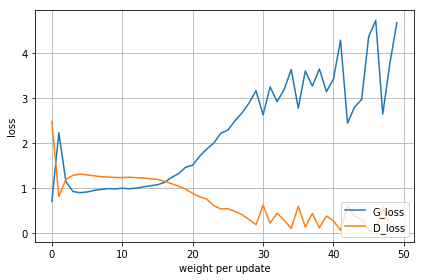

In [4]:
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))) as sess :
    sess.run(tf.global_variables_initializer())

    np.random.seed(int(time.time()))
    tf.set_random_seed(int(time.time()))
    
    
    test_z = np.random.uniform(-1,1,size=(16,1,1,z_size))

    log_txt = open(file_name +'/log.txt','w')

    hist_G = []
    hist_D = []
    G_error = []
    D_error = []
    D_fake_error = []
    D_real_error = []
    
    start = time.time()
    for epoch in range(train_epoch) :
        
        train_normal_data = idx_shuffle(train_normal_data) 
        
        for iteration in range(train_normal_data.shape[0] // batch_size) : 
        
            
            train_images = train_normal_data[iteration*batch_size : (iteration+1)*batch_size]      
            u_ = np.reshape(train_images,(-1,64,64,1)) 
            z_ = np.random.uniform(-1,1,size=(batch_size,1,1,z_size))
            
        
            _ , D_e,D_real_e,D_fake_e = sess.run([D_optim, D_loss,D_real_loss,D_fake_loss], {u : u_, z : z_, isTrain : True})
            D_error.append(D_e)
            D_real_error.append(np.maximum(0.0, D_real_e))
            D_fake_error.append(np.maximum(0.0,D_fake_e))

            #    train_images,train_labels = mnist.train.next_batch(100)    
            #    u_ = np.reshape(train_images,(-1,64,64,1)) 
            #    z_ = np.random.normal(0,1,size=(100,1,1,100))
   
            _ , G_e = sess.run([G_optim, G_loss], {u : u_, z : z_, isTrain : True}) 
            G_error.append(G_e)
        


        hist_D.append(np.mean(D_error)) 
        hist_G.append(np.mean(G_error))

        print('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f'%(np.mean(D_error), np.mean(D_real_error),
            np.mean(D_fake_error), np.mean(G_error)))
        log_txt.write('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f\n'%(np.mean(D_error),
            np.mean(D_real_error), np.mean(D_fake_error), np.mean(G_error)))
      
        r = sess.run([G_sample],feed_dict={z : test_z, isTrain : False})        
        mnist_4by4_save(np.reshape(r,(-1,64,64,1)),file_name + '/result_{}.png'.format(str(epoch).zfill(3)))

        np.random.seed(int(time.time()))


        G_error = []
        D_error = []
        D_fake_error = []     
        D_real_error = []


    log_txt.close()
    gan_loss_graph_save(G_loss = hist_G,D_loss=hist_D,path = file_name + '/loss_graph.png')   
    saver = tf.train.Saver()
    saver.save(sess,file_name + '/para.cktp')

    end = time.time()-start

    print("total time : ",end)

In [5]:
np.array(G_error).shape

(0,)

## network load

In [6]:
if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

G_sample = sess.graph.get_tensor_by_name("G_sample:0")


D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")


D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")





INFO:tensorflow:Restoring parameters from ex_DCGANs_1/para.cktp


In [7]:
one_hot[np.random.randint(0,1,(10))   ]

NameError: name 'one_hot' is not defined

In [ ]:
one_hot = np.eye(10)